In [1]:
# 1. 固定隨機種子
import random
import numpy as np
import tensorflow as tf

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# 2. 套件載入
import os
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# 3. 資料與參數設定
image_dir = 'C:/Users/User/Python/pj2/Gender_classification'
target_size = (128, 128)
batch_size = 32

# 4. ImageDataGenerator（含資料增強）
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    os.path.join(image_dir, 'train'),
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    seed=seed
)

val_generator = datagen.flow_from_directory(
    os.path.join(image_dir, 'train'),
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    seed=seed
)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(image_dir, 'test'),
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# 5. 載入預訓練 DenseNet169 並加上自訂分類器
base_model = tf.keras.applications.DenseNet169(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3)
)
base_model.trainable = True  # fine-tune 

x = base_model.output
x = layers.GlobalAveragePooling2D(name='gap')(x)
x = layers.Dropout(0.3, name='dropout')(x)
output = layers.Dense(1, activation='sigmoid', name='binary_output')(x)

model = models.Model(inputs=base_model.input, outputs=output, name='DenseNet169_Binary')

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 6. EarlyStopping（避免過擬合）
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 7. 模型訓練
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=[early_stop]
)

# 8. 測試集評估
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc:.4f}")

Found 176 images belonging to 2 classes.
Found 44 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Epoch 1/25
6/6 [==============================] - 71s 9s/step - loss: 0.9247 - accuracy: 0.5000 - val_loss: 0.8965 - val_accuracy: 0.4545
Epoch 2/25
6/6 [==============================] - 46s 8s/step - loss: 0.6730 - accuracy: 0.6364 - val_loss: 0.7737 - val_accuracy: 0.6364
Epoch 3/25
6/6 [==============================] - 45s 7s/step - loss: 0.5644 - accuracy: 0.6875 - val_loss: 0.7194 - val_accuracy: 0.6136
Epoch 4/25
6/6 [==============================] - 45s 7s/step - loss: 0.4467 - accuracy: 0.7386 - val_loss: 0.7118 - val_accuracy: 0.6364
Epoch 5/25
6/6 [==============================] - 46s 7s/step - loss: 0.3884 - accuracy: 0.7955 - val_loss: 0.6907 - val_accuracy: 0.6136
Epoch 6/25
6/6 [==============================] - 46s 7s/step - loss: 0.2894 - accuracy: 0.9205 - val_loss: 0.8138 - val_accuracy: 0.5682
Epoch 7/25
6/6 [==============================] - 4

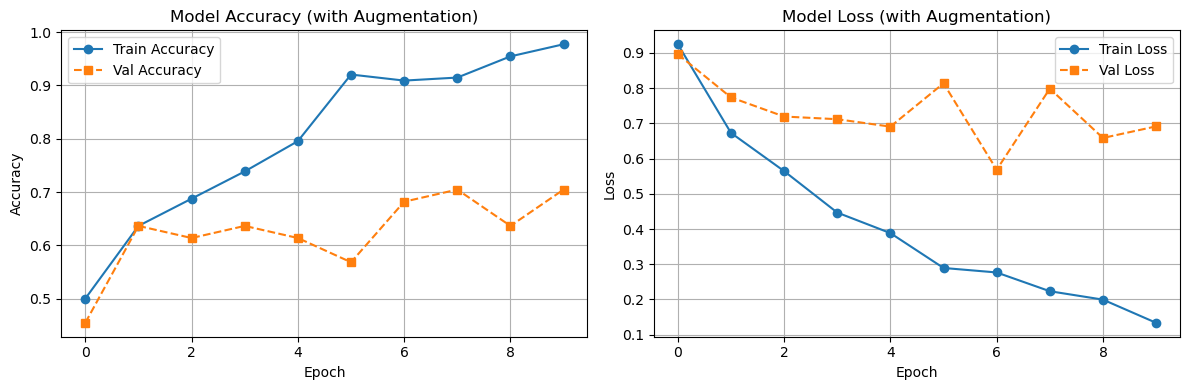

In [2]:
# 9. 畫圖（訓練過程）
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'o-', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], 's--', label='Val Accuracy')
plt.title('Model Accuracy (with Augmentation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'o-', label='Train Loss')
plt.plot(history.history['val_loss'], 's--', label='Val Loss')
plt.title('Model Loss (with Augmentation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()